In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import warnings
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

# Start the spark context
sc = SparkContext.getOrCreate(conf=swan_spark_conf) 

# create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()

# Turn on arrow
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)

21/08/14 16:26:55 WARN Utils: Your hostname, Tristan-PC resolves to a loopback address: 127.0.1.1; using 172.20.65.137 instead (on interface eth0)
21/08/14 16:26:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/14 16:26:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
INFO:SparkMonitorKernel:Client Connected ('127.0.0.1', 44832)


In [69]:
# WEATHER (2018)

# Read in weather data (Laguardia Airport 2018)
LAG2018hr = spark.read.csv("..Hourly weather/LAG 2018.csv", header = True)

# Add some date/time columns and create new df with only relevant columns.
LAG2018hr = LAG2018hr.withColumn("date_only", to_date(LAG2018hr["DATE"]))\
            .withColumn("hour_only", F.hour(LAG2018hr["DATE"]))
LAG2018hr = LAG2018hr.withColumn("Day", F.date_format(LAG2018hr.date_only, "E"))
LAG2018hr = LAG2018hr["DATE", "HourlyDryBulbTemperature", "HourlyPrecipitation", "HourlyWindSpeed", "date_only", "hour_only"]

# Change T flag (trace precipitation amounts) to 0, per the data dictionary.
LAG2018hr = LAG2018hr.withColumn("HourlyPrecipitation", F.when(LAG2018hr["HourlyPrecipitation"] == "T", "0") \
                               .otherwise(LAG2018hr["HourlyPrecipitation"]))

# Limit to 1 record per hour interval
LAG2018hr = LAG2018hr.dropDuplicates(["date_only", "hour_only"]).orderBy("DATE")

df = LAG2018hr.toPandas()

# Drop rows with any null values.
df = df.dropna()

df.to_csv("../Clean/LAG2018hrlyrelevant.csv", index = False)

In [ ]:
rain = LAG2018hr.select("HourlyPrecipitation").distinct().collect()
print(f"Min: {min(rain)}")
print(f"Max: {max(rain)}")

In [3]:
# WEATHER (2019)

# Read in weather data (Laguardia Airport 2019)
LAG2019hr = spark.read.csv("../Hourly weather/LAG 2019.csv", header = True)

# Add some date/time columns, interaction terms and create new df with only relevant columns.
LAG2019hr = LAG2019hr.withColumn("date_only", to_date(LAG2019hr["DATE"]))\
            .withColumn("hour_only", F.hour(LAG2019hr["DATE"]))
LAG2019hr = LAG2019hr.withColumn("Day", F.date_format(LAG2019hr.date_only, "E"))
LAG2019hr = LAG2019hr["DATE", "HourlyDryBulbTemperature", "HourlyPrecipitation", "HourlyWindSpeed", "date_only", "hour_only"]

# Change T flag (trace precipitation amounts) to 0, per the data dictionary.
LAG2019hr = LAG2019hr.withColumn("HourlyPrecipitation", F.when(LAG2019hr["HourlyPrecipitation"] == "T", "0") \
                               .otherwise(LAG2019hr["HourlyPrecipitation"]))

# Limit to 1 record per hour interval
LAG2019hr = LAG2019hr.dropDuplicates(["date_only", "hour_only"]).orderBy("DATE")

df = LAG2019hr.toPandas()

# Drop rows with any null values.
df = df.dropna()

df.to_csv(../"Clean/LAG2019hrlyrelevant.csv", index = False)

In [4]:
# TAXIS (2018 Green)

green18 = spark.read.csv('../TLC Data/Green 2018', header=True)

# The following schema creation code has been almost exactly copied from Akira Wang's MAST30034 pyspark tutorial.
# Can be found at https://github.com/akiratwang/MAST30034_Python
# Some modifications have been made to support Green taxi data.
Gints = ('VendorID', 'passenger_count', 'RatecodeID', 'PULocationID', 'DOLocationID','payment_type', "trip_type")
Gdoubles = ('trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 
           'total_amount', 'congestion_surcharge', 'ehail_fee')
Gstrings = ('store_and_fwd_flag',)
Gdtimes = ('lpep_pickup_datetime', 'lpep_dropoff_datetime')

dtypes = {column: IntegerType() for column in Gints}
dtypes.update({column: DoubleType() for column in Gdoubles})
dtypes.update({column: StringType() for column in Gstrings})
dtypes.update({column: TimestampType() for column in Gdtimes})

Gschema = StructType()

for column in green18.columns:
    Gschema.add(column, 
               dtypes[column], 
               True 
              )
    
green18WSchema = spark.read.csv('../TLC Data/Green 2018', header=True, schema=Gschema)

# Create some custom time columns.
green18WSchema = green18WSchema.withColumn("date_only", to_date(green18WSchema.lpep_pickup_datetime)) \
.withColumn("hour_only", F.hour(green18WSchema.lpep_pickup_datetime)) \
.withColumn("day_only", F.dayofmonth(green18WSchema.lpep_pickup_datetime)) \
.withColumn("month_only", F.month(green18WSchema.lpep_pickup_datetime)) \
.withColumn("year_only", F.year(green18WSchema.lpep_pickup_datetime)) \
.withColumn("Day", F.date_format(green18WSchema.lpep_pickup_datetime, "E"))

# Remove rows without cash or card payment.
green18WSchema = green18WSchema.where((green18WSchema.payment_type == 1) | (green18WSchema.payment_type == 2))

# Remove rows that have a fare amount below the starting fare.
green18WSchema = green18WSchema.where(green18WSchema.fare_amount > 2.50)

# Remove rows with invalid year.
green18WSchema = green18WSchema.where(green18WSchema.year_only == 2018)

# Create trip time, fare rate and log(fare rate) columns.
green18WSchema = green18WSchema.withColumn("PUlong", green18WSchema.lpep_pickup_datetime.cast("long"))\
                .withColumn("DOlong", green18WSchema.lpep_dropoff_datetime.cast("long"))
green18WSchema = green18WSchema.withColumn("trip_time_hr", (green18WSchema.DOlong - green18WSchema.PUlong)/3600)
green18WSchema = green18WSchema.withColumn("hourly_rate", green18WSchema.fare_amount/green18WSchema.trip_time_hr)

# Remove rows with invalid trip times.
green18WSchema = green18WSchema.where(green18WSchema.trip_time_hr > 0)

<AxesSubplot:xlabel='Trip time'>

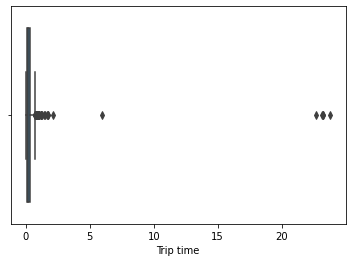

In [5]:
# Trip time distributions.

sample = green18WSchema.sample(fraction = 0.0001, seed = 1).select(green18WSchema.trip_time_hr, \
                                                                  green18WSchema.hourly_rate).collect()
times = [row[0] for row in sample]
boxplot = sns.boxplot(times)
boxplot.set_xlabel("Trip time")
boxplot

In [15]:
# Ratio of trips > 15 hrs. High enough not to remove.

green18WSchema.where(green18WSchema.trip_time_hr > 15).count()/green18WSchema.count()

0.004917159869135727

<AxesSubplot:xlabel='log(Trip time)'>

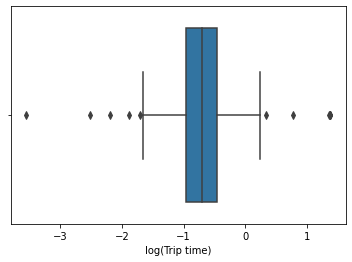

In [7]:
# Try a log transformation.

logtimes = np.log10(times)
boxplot = sns.boxplot(logtimes)
boxplot.set_xlabel("log(Trip time)")
boxplot

In [8]:
# Investigate pickup zones.

PUzones = green18WSchema.select("PULocationID").distinct().collect()
PUzoneslist = [row[0] for row in PUzones]
print(f"Min zone ID: {min(PUzoneslist)}")
print(f"Max zone ID: {max(PUzoneslist)}")

# According to the zone info CSV from TLC, zones 264 and 265 don't really exist.
# https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
# However a large enough portion of our trips are from/to those locations so they will remain in there for now.
green18WSchema.where((green18WSchema.PULocationID  == 264) | (green18WSchema.PULocationID == 265) \
                    | (green18WSchema.DOLocationID == 264) | (green18WSchema.DOLocationID == 265)).count() \
                    / green18WSchema.count()

Min zone ID: 1
Max zone ID: 265


0.0030411924779003563

<AxesSubplot:xlabel='Dollars/hr (fare total only)'>

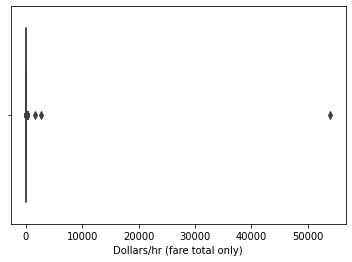

In [9]:
# Investigating fare earned per hour.

rates = [row[1] for row in sample]
boxplot = sns.boxplot(rates)
boxplot.set_xlabel("Dollars/hr (fare total only)")
boxplot

<AxesSubplot:xlabel='log(Dollars/hr) (fare total only)'>

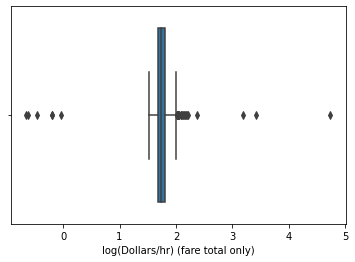

In [10]:
# Try a log transformation.

rateslog = np.log10(rates)
boxplot = sns.boxplot(rateslog)
boxplot.set_xlabel("log(Dollars/hr) (fare total only)")
boxplot

In [68]:
# Add log transformed hourly fare rate to sdf.
green18WSchema = green18WSchema.withColumn("log_rate", F.log(10.0, green18WSchema.hourly_rate))

# Discard irrelevant columns.
green18Relevant = green18WSchema["PULocationID", "DOLocationID", "passenger_count", "fare_amount", "date_only", \
                                "hour_only", "Day", "trip_time_hr", "hourly_rate", "log_rate"]

# Join trips to hourly pick up time weather.
hourJoin = green18Relevant.join(LAG2018hr, (green18Relevant.date_only == LAG2018hr.date_only) & \
                               (green18Relevant.hour_only == LAG2018hr.hour_only))

# Group by hourly pickup intervals. (24*365 groups)
hourGroup = hourJoin.groupBy(green18Relevant.hour_only, green18Relevant.Day, green18Relevant.date_only)\
                                    .agg(F.mean(green18Relevant.log_rate).alias("Average_log_rate"), 
                                    F.mean(green18Relevant.trip_time_hr).alias("Average_trip_time"),
                                    F.mean(LAG2018hr.HourlyDryBulbTemperature).alias("Air_temperature"),
                                    F.mean(LAG2018hr.HourlyPrecipitation).alias("Precipitation"),
                                    F.mean(LAG2018hr.HourlyWindSpeed).alias("Wind_speed"),
                                    F.count(F.lit(1)).alias("Num_trips"))

# Scale continuous values and save.
groupdf = hourGroup.toPandas()
groupdf = groupdf.dropna()
groupdf = pd.get_dummies(groupdf, columns = ["Day", "hour_only"])
groupdf = groupdf.drop("date_only", axis = 1)

# Partition into train and test datasets and scale based on train.
train, test = train_test_split(groupdf, test_size = 0.2, random_state = 1)

scaler = StandardScaler()
train.loc[:, "Average_trip_time" : "Num_trips"] = scaler.fit_transform(train.loc[:, "Average_trip_time" : "Num_trips"])
test.loc[:, "Average_trip_time" : "Num_trips"] = scaler.transform(test.loc[:, "Average_trip_time" : "Num_trips"])
train["TempxWind"] = train["Air_temperature"]*train["Wind_speed"]
train["TempxPrcp"] = train["Air_temperature"]*train["Precipitation"]
train["WindxPrcp"] = train["Wind_speed"]*train["Precipitation"]
test["TempxWind"] = test["Air_temperature"]*test["Wind_speed"]
test["TempxPrcp"] = test["Air_temperature"]*test["Precipitation"]
test["WindxPrcp"] = test["Wind_speed"]*test["Precipitation"]
train.to_csv("../Clean/hourGroup18train.csv", index = False)
test.to_csv("../Clean/hourGroup18test.csv", index = False)

In [13]:
# TAXIS (Green 2019)
# Follows all the same cleaning. Scaled according to 2018 data.

green19WSchema = spark.read.csv('../TLC Data/Green 2019', header=True, schema=Gschema)

# Create some custom time columns.
green19WSchema = green19WSchema.withColumn("date_only", to_date(green19WSchema.lpep_pickup_datetime)) \
.withColumn("hour_only", F.hour(green19WSchema.lpep_pickup_datetime)) \
.withColumn("day_only", F.dayofmonth(green19WSchema.lpep_pickup_datetime)) \
.withColumn("month_only", F.month(green19WSchema.lpep_pickup_datetime)) \
.withColumn("year_only", F.year(green19WSchema.lpep_pickup_datetime)) \
.withColumn("Day", F.date_format(green19WSchema.lpep_pickup_datetime, "E"))

# Remove rows without cash or card payment.
green19WSchema = green19WSchema.where((green19WSchema.payment_type == 1) | (green19WSchema.payment_type == 2))

# Remove rows that have a fare amount below the starting fare.
green19WSchema = green19WSchema.where(green19WSchema.fare_amount > 2.50)

# Remove rows with invalid year.
green19WSchema = green19WSchema.where(green19WSchema.year_only == 2019)

# Create trip time, fare rate and log(fare rate) columns.
green19WSchema = green19WSchema.withColumn("PUlong", green19WSchema.lpep_pickup_datetime.cast("long"))\
                .withColumn("DOlong", green19WSchema.lpep_dropoff_datetime.cast("long"))
green19WSchema = green19WSchema.withColumn("trip_time_hr", (green19WSchema.DOlong - green19WSchema.PUlong)/3600)
green19WSchema = green19WSchema.withColumn("hourly_rate", green19WSchema.fare_amount/green19WSchema.trip_time_hr)

# Remove rows with invalid trip times.
green19WSchema = green19WSchema.where(green19WSchema.trip_time_hr > 0)

# Add log transformed hourly fare rate to sdf.
green19WSchema = green19WSchema.withColumn("log_rate", F.log(10.0, green19WSchema.hourly_rate))

# Discard irrelevant columns.
green19Relevant = green19WSchema["passenger_count", "fare_amount", "date_only", \
                                "hour_only", "Day", "trip_time_hr", "hourly_rate", "log_rate"]

# Join trips to hourly pick up time weather.
hourJoin = green19Relevant.join(LAG2019hr, (green19Relevant.date_only == LAG2019hr.date_only) & \
                               (green19Relevant.hour_only == LAG2019hr.hour_only))

# Group by hourly pickup intervals. (24*365 groups)
hourGroup = hourJoin.groupBy(green19Relevant.hour_only, green19Relevant.Day, green19Relevant.date_only)\
                                    .agg(F.mean(green19Relevant.log_rate).alias("Average_log_rate"), 
                                    F.mean(green19Relevant.trip_time_hr).alias("Average_trip_time"),
                                    F.mean(LAG2019hr.HourlyDryBulbTemperature).alias("Air_temperature"),
                                    F.mean(LAG2019hr.HourlyPrecipitation).alias("Precipitation"),
                                    F.mean(LAG2019hr.HourlyWindSpeed).alias("Wind_speed"),
                                    F.count(F.lit(1)).alias("Num_trips"))

# Scale continuous values and save.
groupdf = hourGroup.toPandas()
groupdf = groupdf.dropna()
groupdf = groupdf.drop("date_only", axis = 1)
groupdf.loc[:, "Average_trip_time" : "Num_trips"] = scaler.transform(groupdf.loc[:, "Average_trip_time" : "Num_trips"])
groupdf["TempxWind"] = groupdf["Air_temperature"]*groupdf["Wind_speed"]
groupdf["TempxPrcp"] = groupdf["Air_temperature"]*groupdf["Precipitation"]
groupdf["WindxPrcp"] = groupdf["Wind_speed"]*groupdf["Precipitation"]
groupdf.to_csv("../Clean/hourGroup19.csv", index = False)